# NLP Model for Weather Query Understanding
This notebook trains a BiLSTM model with BERT embeddings for intent classification & Named Entity Recognition (NER).

## Packages

In [9]:
import json
import torch
import numpy as np
import pandas as pd
import sys
!{sys.executable} -m pip install transformers TorchCRF dateparser

from transformers import BertTokenizerFast
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from transformers import BertModel
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score
from TorchCRF import CRF
import os
import re
import matplotlib.pyplot as plt
from collections import Counter
import torch
import random
from typing import Dict, Any
import requests
import matplotlib.pyplot as plt
import pytz
from datetime import datetime
from dateutil import parser, relativedelta
import dateparser


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Environment Variables

In [10]:
# api key for watherapi.com
API_KEY = "6598d1fbebc24041896182152251402"
BASE_URL = "https://api.weatherapi.com/v1"

## Loading and Preprocessing

### Defining Intents Labels and IDs and Data Splitting

In [11]:
# Load dataset
with open("weather_fixed.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# Load BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

# Define intent labels
intent_labels = ["weather_forecast", "yes_no_weather", "clothing_recommendation", "yes_no_clothing"]
intent2idx = {intent: idx for idx, intent in enumerate(intent_labels)}

# Define entity labels for BIO tagging
entity_labels = ["O", "B-condition", "I-condition", "B-outfit", "I-outfit", "B-address", "I-address", "B-temperature", "I-temperature", "B-date-time", "I-date-time"]
entity2idx = {label: idx for idx, label in enumerate(entity_labels)}

# Function to convert entities into BIO format
def get_bio_tags(tokens, entities=None):
    tags = ["O"] * len(tokens)  # Default is "O" (Outside)
    
    if entities:  # Only process if entities exist
        for entity_type, entity_value in entities.items():
            if isinstance(entity_value, list):  # If multiple entities exist
                for value in entity_value:
                    entity_tokens = tokenizer.tokenize(value)
                    for i, token in enumerate(entity_tokens):
                        tag = f"B-{entity_type}" if i == 0 else f"I-{entity_type}"
                        if tag in entity2idx:
                            try:
                                idx = tokens.index(token)
                                tags[idx] = tag
                            except ValueError:
                                pass  # Token not found in query tokens
            else:  # Single entity case
                entity_tokens = tokenizer.tokenize(entity_value)
                for i, token in enumerate(entity_tokens):
                    tag = f"B-{entity_type}" if i == 0 else f"I-{entity_type}"
                    if tag in entity2idx:
                        try:
                            idx = tokens.index(token)
                            tags[idx] = tag
                        except ValueError:
                            pass  # Token not found in query tokens

    return [entity2idx[tag] for tag in tags]

# Process dataset
sentences, intent_labels_idx, entity_labels_idx = [], [], []
for entry in tqdm(data):
    tokens = tokenizer.tokenize(entry["query"])
    intent_idx = [intent2idx[intent] for intent in entry["intents"]]
    # Pass entities if they exist, otherwise pass None
    entity_idx = get_bio_tags(tokens, entry.get("entities"))
    
    sentences.append(tokens)
    intent_labels_idx.append(intent_idx)
    entity_labels_idx.append(entity_idx)

# Train-test split
train_texts, test_texts, train_intents, test_intents, train_entities, test_entities = train_test_split(
    sentences, intent_labels_idx, entity_labels_idx, test_size=0.1, random_state=42
)

100%|██████████| 4706/4706 [00:01<00:00, 4692.32it/s]


### Check on Intents, Entities and Splits

In [12]:
print(f"Training samples: {len(train_texts)}, Test samples: {len(test_texts)}")
# Debugging BIO tagging alignment
for i in range(5):
    print("Tokens:", train_texts[i])
    print("Entities:", train_entities[i])
    print("BIO Mapped:", [entity_labels[idx] for idx in train_entities[i]])
    print("\n")

Training samples: 4235, Test samples: 471
Tokens: ['what', 'are', 'some', 'good', 'clothing', 'options', 'for', 'a', 'day', 'that', 'might', 'be', 'over', '##cast', 'but', 'still', 'quite', 'warm', ',', 'do', 'you', 'have', 'any', 'recommendations', '?']
Entities: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0]
BIO Mapped: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-condition', 'I-condition', 'O', 'O', 'O', 'B-temperature', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


Tokens: ['is', 'there', 'a', 'chance', 'of', 'snow', 'and', 'ice', 'later', '?']
Entities: [0, 0, 0, 0, 0, 1, 0, 1, 9, 0]
BIO Mapped: ['O', 'O', 'O', 'O', 'O', 'B-condition', 'O', 'B-condition', 'B-date-time', 'O']


Tokens: ['what', 'are', 'ideal', 'clothing', 'choices', 'for', 'a', 'day', 'with', 'a', 'light', 'breeze', 'and', 'partly', 'cloudy', 'skies', '?']
Entities: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 1, 2, 2, 0]
BIO Mapped: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O

### Data Analysis

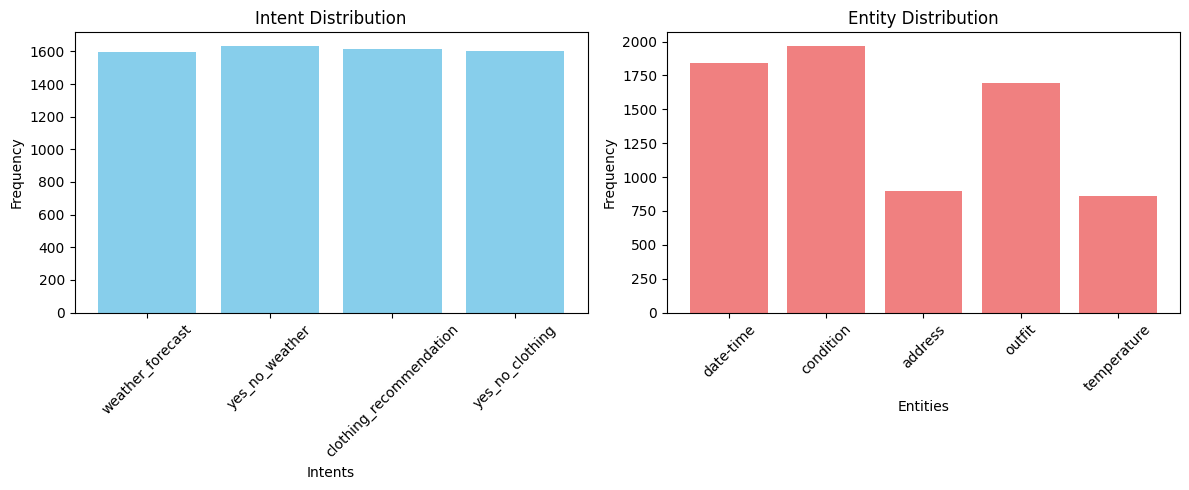

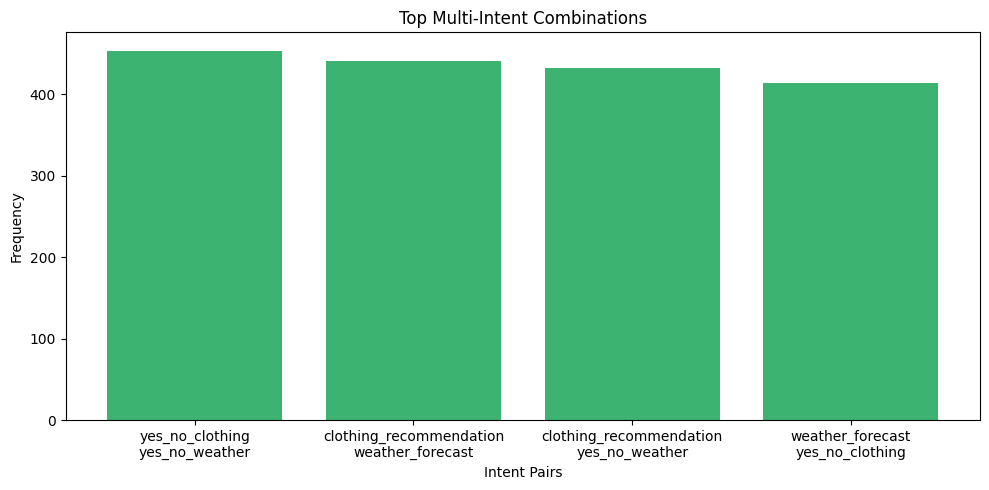

Counter({('yes_no_clothing', 'yes_no_weather'): 453,
         ('clothing_recommendation', 'weather_forecast'): 441,
         ('clothing_recommendation', 'yes_no_weather'): 432,
         ('weather_forecast', 'yes_no_clothing'): 413})

In [13]:
# Load dataset
file_path = "./weather_fixed.json"
with open(file_path, "r", encoding="utf-8") as f:
    dataset = json.load(f)

# Count intent and entity occurrences
intent_counter = Counter()
entity_counter = Counter()
multi_intent_combinations = Counter()

for sample in dataset:
    # Count intents
    intents = sample.get("intents", [])
    for intent in intents:
        intent_counter[intent] += 1

    # Count multi-intent combinations
    if len(intents) > 1:
        sorted_intents = tuple(sorted(intents))  # Sort to avoid duplicates
        multi_intent_combinations[sorted_intents] += 1

    # Count entities
    entities = sample.get("entities", {})
    if isinstance(entities, dict):  
        for entity_type in entities.keys():
            entity_counter[entity_type] += 1

# Function to plot intent and entity distributions
def plot_intent_entity_distributions(intent_counter, entity_counter):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Plot intent distribution
    axes[0].bar(intent_counter.keys(), intent_counter.values(), color='skyblue')
    axes[0].set_title("Intent Distribution")
    axes[0].set_xlabel("Intents")
    axes[0].set_ylabel("Frequency")
    axes[0].tick_params(axis='x', rotation=45)

    # Plot entity distribution
    axes[1].bar(entity_counter.keys(), entity_counter.values(), color='lightcoral')
    axes[1].set_title("Entity Distribution")
    axes[1].set_xlabel("Entities")
    axes[1].set_ylabel("Frequency")
    axes[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

# Function to plot multi-intent combinations
def plot_multi_intent_combinations(multi_intent_combinations):
    fig, ax = plt.subplots(figsize=(10, 5))

    # Plot multi-intent distribution (top 10 most common)
    top_multi_intents = multi_intent_combinations.most_common(10)
    multi_intent_labels = ["\n".join(list(combo)) for combo, _ in top_multi_intents]  # Format labels nicely
    multi_intent_values = [count for _, count in top_multi_intents]

    ax.bar(multi_intent_labels, multi_intent_values, color='mediumseagreen')
    ax.set_title("Top Multi-Intent Combinations")
    ax.set_xlabel("Intent Pairs")
    ax.set_ylabel("Frequency")
    ax.tick_params(axis='x', rotation=0)  # Keep labels readable

    plt.tight_layout()
    plt.show()

# Run functions
plot_intent_entity_distributions(intent_counter, entity_counter)
plot_multi_intent_combinations(multi_intent_combinations)

# Return multi-intent combinations for further analysis
multi_intent_combinations

### Converting for PyTorch

In [14]:
class WeatherDataset(Dataset):
    def __init__(self, texts, intents, entities, intent2idx, entity2idx, max_length=75):
        self.texts = texts  # List of pre-tokenized tokens
        self.intents = intents  # List of intent index lists
        self.entities = entities  # List of entity index lists from get_bio_tags
        self.intent2idx = intent2idx
        self.entity2idx = entity2idx
        self.tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        tokens = self.texts[idx]  # Pre-tokenized tokens
        intent = self.intents[idx]  # List of intent indices

        # Multi-hot encode intents
        intent_tensor = torch.zeros(len(self.intent2idx), dtype=torch.float)
        for i in intent:
            intent_tensor[i] = 1  # Mark intent positions as 1

        # Use precomputed entity indices, default to all "O" if empty
        entity_ids = self.entities[idx] if self.entities[idx] else [self.entity2idx["O"]] * len(tokens)

        # Tokenize and pad the pre-tokenized sequence
        encoding = self.tokenizer.encode_plus(
            tokens,
            is_split_into_words=True,  # Input is already tokenized
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )

        # Pad or truncate entity_ids to match max_length
        padded_entity_ids = entity_ids + [self.entity2idx["O"]] * (self.max_length - len(entity_ids))
        padded_entity_ids = padded_entity_ids[:self.max_length]  # Trim if too long

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "intent": intent_tensor,  # Multi-hot encoded
            "entity_labels": torch.tensor(padded_entity_ids, dtype=torch.long)
        }

# Assuming train_texts, train_intents, train_entities, etc. are already defined from your previous code
train_dataset = WeatherDataset(train_texts, train_intents, train_entities, intent2idx, entity2idx)
test_dataset = WeatherDataset(test_texts, test_intents, test_entities, intent2idx, entity2idx)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

### Checking on the WeatherDataset Class

In [15]:
# Debugging output
for i in range(5):
    print("Original Intent Labels:", train_intents[i])
    print("Multi-Hot Encoded Intent Tensor:", train_dataset[i]["intent"])
    print("\n")

for i in range(5):
    print("Tokens:", train_texts[i])
    print("Entity Indices (precomputed):", train_entities[i])
    print("Entity Labels Mapped to Tokens:", [entity_labels[idx] for idx in train_entities[i]])
    print("\n")

# Batch shapes
for batch in train_loader:
    print("input_ids shape:", batch["input_ids"].shape)
    print("attention_mask shape:", batch["attention_mask"].shape)
    print("intent shape:", batch["intent"].shape)
    print("entity_labels shape:", batch["entity_labels"].shape)
    print("Sample entity_labels[10]:", batch["entity_labels"][10])
    break

Original Intent Labels: [2, 1]
Multi-Hot Encoded Intent Tensor: tensor([0., 1., 1., 0.])


Original Intent Labels: [1]
Multi-Hot Encoded Intent Tensor: tensor([0., 1., 0., 0.])


Original Intent Labels: [2]
Multi-Hot Encoded Intent Tensor: tensor([0., 0., 1., 0.])


Original Intent Labels: [1, 3]
Multi-Hot Encoded Intent Tensor: tensor([0., 1., 0., 1.])


Original Intent Labels: [1, 3]
Multi-Hot Encoded Intent Tensor: tensor([0., 1., 0., 1.])


Tokens: ['what', 'are', 'some', 'good', 'clothing', 'options', 'for', 'a', 'day', 'that', 'might', 'be', 'over', '##cast', 'but', 'still', 'quite', 'warm', ',', 'do', 'you', 'have', 'any', 'recommendations', '?']
Entity Indices (precomputed): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0]
Entity Labels Mapped to Tokens: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-condition', 'I-condition', 'O', 'O', 'O', 'B-temperature', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


Tokens: ['is', 'there', 'a', 'chance', '

## Model Building

In [16]:
class BiLSTM_IntentNER(nn.Module):
    def __init__(self, num_intents, num_entities):
        super(BiLSTM_IntentNER, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")  # ✅ Fine-tuning enabled
        
        # BiLSTM for sequence modeling
        self.lstm = nn.LSTM(input_size=768, hidden_size=256, num_layers=2, bidirectional=True, batch_first=True)
        
        # Intent classification head
        self.intent_classifier = nn.Linear(512, num_intents)
        
        # NER classifier (Softmax output)
        self.ner_classifier = nn.Linear(512, num_entities)  

    def forward(self, input_ids, attention_mask):
        embeddings = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state  
        lstm_out, _ = self.lstm(embeddings)

        # Intent classification (CLS token)
        intent_logits = self.intent_classifier(lstm_out[:, 0, :])  

        # NER classification (Softmax output)
        ner_logits = self.ner_classifier(lstm_out)  

        return intent_logits, ner_logits
    
# Initialize Model and Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BiLSTM_IntentNER(len(intent2idx), len(entity2idx)).to(device)
optimizer = optim.AdamW(model.parameters(), lr=2e-5)

## Train the Model

In [17]:
# Compute Weighted Loss for NER
num_labels = len(entity2idx)
label_counts = torch.zeros(num_labels)

for labels in train_entities:
    for label in labels:
        label_counts[label] += 1  # Count occurrences

# Compute class weights (inverse frequency)
class_weights = 1.0 / (label_counts + 1e-5)
class_weights /= class_weights.sum()

# Apply weighted loss
criterion_intent = nn.BCEWithLogitsLoss()
criterion_ner = nn.CrossEntropyLoss(weight=class_weights.to(device))


# Compute Metrics Function
def compute_metrics(intent_logits, intent_labels, ner_logits, entity_labels):
    intent_preds = (torch.sigmoid(intent_logits) > 0.5).cpu().numpy()
    intent_true = intent_labels.cpu().numpy()
    intent_acc = accuracy_score(intent_true, intent_preds)
    intent_f1 = f1_score(intent_true, intent_preds, average='micro')

    ner_preds = torch.argmax(ner_logits, dim=-1).cpu().numpy().flatten()
    ner_true = entity_labels.cpu().numpy().flatten()
    ner_acc = accuracy_score(ner_true, ner_preds)
    ner_f1 = f1_score(ner_true, ner_preds, average='macro')

    return intent_acc, intent_f1, ner_acc, ner_f1

# Directory for saving models
checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
best_model_path = os.path.join(checkpoint_dir, "best_model.pt")
checkpoint_path_template = os.path.join(checkpoint_dir, "checkpoint_epoch_{}.pt")

# Training & Evaluation Loop with Saving
num_epochs = 3
best_metric = -float('inf')  # Track best combined Intent F1 + NER F1

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    total_loss = 0
    intent_acc_train, intent_f1_train, ner_acc_train, ner_f1_train = [], [], [], []

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)
    for batch in train_bar:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        intent_labels = batch["intent"].to(device)
        entity_labels = batch["entity_labels"].to(device)

        optimizer.zero_grad()
        intent_logits, ner_logits = model(input_ids, attention_mask)

        # Compute loss
        loss_intent = criterion_intent(intent_logits, intent_labels)
        loss_ner = criterion_ner(ner_logits.view(-1, len(entity2idx)), entity_labels.view(-1))
        loss = loss_intent + loss_ner

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Compute training metrics
        i_acc, i_f1, n_acc, n_f1 = compute_metrics(intent_logits, intent_labels, ner_logits, entity_labels)
        intent_acc_train.append(i_acc)
        intent_f1_train.append(i_f1)
        ner_acc_train.append(n_acc)
        ner_f1_train.append(n_f1)

        train_bar.set_postfix({
            "Loss": f"{total_loss / (train_bar.n + 1):.4f}",
            "Intent F1": f"{np.mean(intent_f1_train):.4f}",
            "NER F1": f"{np.mean(ner_f1_train):.4f}"
        })

    # Evaluation Phase
    model.eval()
    eval_loss = 0
    intent_acc_eval, intent_f1_eval, ner_acc_eval, ner_f1_eval = [], [], [], []

    eval_bar = tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Eval]", leave=False)
    with torch.no_grad():
        for batch in eval_bar:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            intent_labels = batch["intent"].to(device)
            entity_labels = batch["entity_labels"].to(device)

            intent_logits, ner_logits = model(input_ids, attention_mask)

            loss_intent = criterion_intent(intent_logits, intent_labels)
            loss_ner = criterion_ner(ner_logits.view(-1, len(entity2idx)), entity_labels.view(-1))
            loss = loss_intent + loss_ner
            eval_loss += loss.item()

            i_acc, i_f1, n_acc, n_f1 = compute_metrics(intent_logits, intent_labels, ner_logits, entity_labels)
            intent_acc_eval.append(i_acc)
            intent_f1_eval.append(i_f1)
            ner_acc_eval.append(n_acc)
            ner_f1_eval.append(n_f1)

            eval_bar.set_postfix({
                "Loss": f"{eval_loss / (eval_bar.n + 1):.4f}",
                "Intent F1": f"{np.mean(intent_f1_eval):.4f}",
                "NER F1": f"{np.mean(ner_f1_eval):.4f}"
            })

    # Compute average metrics for the epoch
    avg_intent_f1_eval = np.mean(intent_f1_eval)
    avg_ner_f1_eval = np.mean(ner_f1_eval)
    combined_metric = (avg_intent_f1_eval + avg_ner_f1_eval) / 2  # Combined metric for best model

    # Print epoch summary
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {total_loss / len(train_loader):.4f}, "
          f"Intent Acc: {np.mean(intent_acc_train):.4f}, Intent F1: {np.mean(intent_f1_train):.4f}, "
          f"NER Acc: {np.mean(ner_acc_train):.4f}, NER F1: {np.mean(ner_f1_train):.4f}")
    print(f"Eval Loss: {eval_loss / len(test_loader):.4f}, "
          f"Intent Acc: {np.mean(intent_acc_eval):.4f}, Intent F1: {avg_intent_f1_eval:.4f}, "
          f"NER Acc: {np.mean(ner_acc_eval):.4f}, NER F1: {avg_ner_f1_eval:.4f}")
    
    # Save checkpoint after each epoch
    checkpoint_path = checkpoint_path_template.format(epoch + 1)
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': total_loss / len(train_loader),
        'eval_loss': eval_loss / len(test_loader),
        'intent_f1': avg_intent_f1_eval,
        'ner_f1': avg_ner_f1_eval
    }, checkpoint_path)
    print(f"Saved checkpoint: {checkpoint_path}")

    # Save best model based on combined metric
    if combined_metric > best_metric:
        best_metric = combined_metric
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'intent_f1': avg_intent_f1_eval,
            'ner_f1': avg_ner_f1_eval
        }, best_model_path)
        print(f"Saved best model: {best_model_path} (Combined F1: {combined_metric:.4f})")

    print("-" * 80)

KeyboardInterrupt: 

## Model Testing

### Loading Best Model

In [19]:
best_model_path = "best_model.pt"
# Load best model for inference
print(f"Loading best model from {best_model_path} for inference...")
checkpoint = torch.load(best_model_path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
print(f"Best model loaded from epoch {checkpoint['epoch']} with Intent F1: {checkpoint['intent_f1']:.4f}, NER F1: {checkpoint['ner_f1']:.4f}")

Loading best model from best_model.pt for inference...
Best model loaded from epoch 3 with Intent F1: 0.9956, NER F1: 0.5765


### Applying Output Predictions

In [20]:
def predict_intent_and_entities(model, query, tokenizer, intent2idx, entity2idx, max_length=32):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Convert index-to-label mappings
    idx2intent = {v: k for k, v in intent2idx.items()}
    idx2entity = {v: k for k, v in entity2idx.items()}

    # Tokenize input
    encoding = tokenizer.encode_plus(
        query,
        truncation=True,
        padding="max_length",
        max_length=max_length,
        return_tensors="pt"
    )
    
    input_ids = encoding["input_ids"].to(device)
    attention_mask = encoding["attention_mask"].to(device)

    # Get model predictions
    with torch.no_grad():
        intent_logits, ner_logits = model(input_ids, attention_mask)
    
    # Decode intents
    intent_preds = (torch.sigmoid(intent_logits) > 0.5).cpu().numpy().flatten()
    predicted_intents = [idx2intent[i] for i in range(len(intent_preds)) if intent_preds[i] == 1]

    # Decode NER labels
    ner_preds = torch.argmax(ner_logits, dim=-1).cpu().numpy().flatten()
    tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())
    
    entity_predictions = []
    for token, label_idx in zip(tokens, ner_preds):
        label = idx2entity[label_idx]
        if label != "O":  # Ignore "O" tokens
            entity_predictions.append((token, label))

    return {
        "query": query,
        "predicted_intents": predicted_intents,
        "named_entities": entity_predictions
    }


test_queries = [
    # Simple weather forecast
    "What's the weather like today?",  
    "Will it be sunny tomorrow?",  
    "How's the weather looking for next weekend?",  
    "Is it going to rain this evening?",  
    "Tell me the temperature for the next 3 days.",  

    # Clothing recommendations  
    "What should I wear today?",  
    "Is a sweater necessary for tonight?",  
    "Would a raincoat be a good idea for tomorrow?",  
    "Do I need gloves if it's freezing?",  
    "Can I wear shorts in this weather?",  

    # Yes/No Weather + Clothing  
    "Will I need an umbrella today?",  
    "Is it too hot for a jacket?",  
    "Would a hat be useful if it's sunny?",  
    "Is it snowing right now?",  
    "Should I take my sunglasses with me?",  

    # Location-based queries  
    "What's the weather like in Paris next Friday?",  
    "Tell me the forecast for Tokyo next Monday.",  
    "Will it be windy in London tomorrow?",  
    "Is it raining in Cairo right now?",  
    "Can I expect a storm in New York this weekend?",  

    # Multi-Intent Queries  
    "Whats the weather for next Sunday, and can I wear a tank top?",  
    "Is it going to be cold tonight, and what should I wear?",  
    "Can I wear sandals tomorrow, or is it going to rain?",  
    "Do I need a coat and will it be windy?",  
    "Tell me the weather forecast for next week and recommend an outfit.",  

    # Complex Clothing + Weather  
    "What should I wear for a snowy day?",  
    "Is it too hot for a hoodie and should I wear a hat?",  
    "Will it be humid, and should I take a light jacket?",  
    "Is the weather cold enough for a scarf?",  
    "Tell me if it's raining and what kind of shoes I should wear.",  

    # Extreme Weather Scenarios  
    "Should I prepare for a thunderstorm tomorrow?",  
    "Is there a high chance of snow next weekend?",  
    "Do I need a raincoat or will it just be cloudy?",  
    "Is the wind strong enough to need a windbreaker?",  
    "Will it be foggy in the morning, and do I need warm clothes?",  
]


for query in test_queries:
    result = predict_intent_and_entities(model, query, tokenizer, intent2idx, entity2idx)
    print(result)
    print("-" * 80)


{'query': "What's the weather like today?", 'predicted_intents': ['weather_forecast'], 'named_entities': [('like', 'B-date-time'), ('today', 'B-date-time')]}
--------------------------------------------------------------------------------
{'query': 'Will it be sunny tomorrow?', 'predicted_intents': ['yes_no_weather'], 'named_entities': [('it', 'B-condition'), ('be', 'B-condition'), ('sunny', 'B-date-time'), ('tomorrow', 'B-date-time')]}
--------------------------------------------------------------------------------
{'query': "How's the weather looking for next weekend?", 'predicted_intents': ['weather_forecast'], 'named_entities': [('for', 'B-date-time'), ('next', 'I-date-time'), ('weekend', 'I-date-time')]}
--------------------------------------------------------------------------------
{'query': 'Is it going to rain this evening?', 'predicted_intents': ['yes_no_weather'], 'named_entities': [('going', 'B-condition'), ('to', 'B-condition'), ('rain', 'B-date-time'), ('this', 'I-date-ti

### Entity Extraction

In [21]:
# Load classified weather conditions and clothing items
with open("./classified_weather_conditions.json", "r", encoding="utf-8") as f:
    weather_dict = json.load(f)

with open("./classified_clothing_items.json", "r", encoding="utf-8") as f:
    clothing_dict = json.load(f)

# Define common date and time expressions
date_keywords = {"today", "tomorrow", "yesterday", "tonight", "morning", "afternoon", "evening", "night"}
week_days = {"monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday"}
relative_dates = {"next", "last", "this"}

# Fixed regex for detecting time formats
time_patterns = r"\b\d{1,2}(:\d{2})?\s?(am|pm)?\b"

# Flatten dictionary categories for lookup
all_weather_terms = set(sum(weather_dict.values(), []))
all_clothing_terms = set()

for key, value in clothing_dict.items():
    if isinstance(value, dict):  # Handle nested dictionaries (e.g., "temperature")
        for sublist in value.values():
            all_clothing_terms.update(sublist)
    elif isinstance(value, list):  # Handle direct lists (e.g., "rain")
        all_clothing_terms.update(value)

# Function to extract entities
def extract_entities(sentence):
    # Preprocess sentence
    sentence = sentence.lower()
    sentence = re.sub(r"[^\w\s]", "", sentence)  # Remove punctuation
    words = sentence.split()  # Tokenize sentence into words

    # Extract entities
    extracted_weather = [word for word in words if word in all_weather_terms]
    extracted_clothing = [word for word in words if word in all_clothing_terms]
    
    # Extract date mentions
    extracted_dates = []
    for i, word in enumerate(words):
        if word in date_keywords or word in week_days:
            # Handle relative dates like "next Monday"
            if i > 0 and words[i - 1] in relative_dates:
                extracted_dates.append(f"{words[i - 1]} {word}")
            else:
                extracted_dates.append(word)

    # Extract times correctly
    extracted_times = [match.group().strip() for match in re.finditer(time_patterns, sentence) if match.group().strip()]

    return {
        "weather_conditions": extracted_weather,
        "clothing_items": extracted_clothing,
        "dates": extracted_dates,
        "times": extracted_times
    }

### Entity Extraction Test

In [22]:
# Example usage
for sentence in test_queries:
    print(f"Sentence: {sentence}")
    entities = extract_entities(sentence)
    print("Extracted Entities:", entities)
    print("-" * 80)

Sentence: What's the weather like today?
Extracted Entities: {'weather_conditions': [], 'clothing_items': [], 'dates': ['today'], 'times': []}
--------------------------------------------------------------------------------
Sentence: Will it be sunny tomorrow?
Extracted Entities: {'weather_conditions': ['sunny'], 'clothing_items': [], 'dates': ['tomorrow'], 'times': []}
--------------------------------------------------------------------------------
Sentence: How's the weather looking for next weekend?
Extracted Entities: {'weather_conditions': [], 'clothing_items': [], 'dates': [], 'times': []}
--------------------------------------------------------------------------------
Sentence: Is it going to rain this evening?
Extracted Entities: {'weather_conditions': ['rain'], 'clothing_items': [], 'dates': ['this evening'], 'times': []}
--------------------------------------------------------------------------------
Sentence: Tell me the temperature for the next 3 days.
Extracted Entities: {

# Weather API

## Date in YYYY-MM-DD Format

In [23]:
def parse_date(query):
    today = datetime.now()
    if "next" in query:
        day_name = query.split()[1]
        target_day = parser.parse(day_name).weekday()
        days_ahead = target_day - today.weekday()
        if days_ahead <= 0:
            days_ahead += 7
        date = today + relativedelta.relativedelta(days=days_ahead)

    elif "last" in query:
        day_name = query.split()[1]
        target_day = parser.parse(day_name).weekday()
        days_behind = today.weekday() - target_day
        if days_behind <= 0:
            days_behind += 7
        date = today - relativedelta.relativedelta(days=days_behind)
    
    elif "this" in query:
        day_name = query.split()[1]
        target_day = parser.parse(day_name).weekday()
        days_ahead = target_day - today.weekday()
        date = today + relativedelta.relativedelta(days=days_ahead)
        
    elif "tonight" in query:
        # treat it as today
        date = today

    else:
        date = dateparser.parse(query, settings={'RELATIVE_BASE': datetime.now()})
    
    if date:
        # Calculate the difference in days
        days_difference = (date - today).days
        return date.strftime("%Y-%m-%d"), days_difference
    else:
        return None, None

## Date Test

In [24]:
# Example queries to parse
dates = ["this Friday", "next Friday", "next Monday", "last Monday", "Monday", "this Monday", "this Wednesday", "tomorrow", "yesterday", "today", "this Sunday", "tonight"]
for date in dates:
    parsed_date, days_difference = parse_date(date)
    print(f"{date}: {parsed_date}, Days from today: {days_difference}")

this Friday: 2025-05-02, Days from today: -2
next Friday: 2025-05-09, Days from today: 5
next Monday: 2025-05-05, Days from today: 1
last Monday: 2025-04-28, Days from today: -6
Monday: 2025-05-28, Days from today: 23
this Monday: 2025-04-28, Days from today: -6
this Wednesday: 2025-04-30, Days from today: -4
tomorrow: 2025-05-05, Days from today: 1
yesterday: 2025-05-03, Days from today: -1
today: 2025-05-04, Days from today: 0
this Sunday: 2025-05-04, Days from today: 0
tonight: 2025-05-04, Days from today: 0


## Location & Timezone

In [25]:
def get_location_and_timezone():
    try:
        response = requests.get('https://ipinfo.io')
        data = response.json()
        loc = data['loc'].split(',')
        latitude = float(loc[0])
        longitude = float(loc[1])
        timezone_str = data['timezone']
        timezone = pytz.timezone(timezone_str)
        return timezone.zone, latitude, longitude
    except Exception as e:
        print(f"Error getting location and timezone: {e}")
        return None

## Location Test

In [26]:
# Example queries to parse
print(get_location_and_timezone())

('Africa/Cairo', 30.4598, 31.1842)


## Time in 24 - Hour Format

In [27]:
# Time parser into 24-hour format
def parse_time(query, timezone="Africa/Cairo"):
    if query.lower() == "night":
        query = "midnight"
    elif query.lower() == "morning":
        query = "8 AM"
    elif query.lower() == "afternoon":
        query = "3 PM"
    elif query.lower() == "evening":
        query = "8 PM"
    
    time = dateparser.parse(query, settings={'TIMEZONE': timezone})
    return time.strftime("%H") if time else None

## Time Test

In [28]:
# Example queries to parse
timezone, latitude, longitude = get_location_and_timezone()
print(f"Timezone: {timezone}, Latitude: {latitude}, Longitude: {longitude}")
time_queries = ["3pm", "5 PM", "10:30 AM", "12:45 PM", "8:30", "15:30", "22:00", "midnight", "noon", "morning", "afternoon", "evening", "night", "now"]
for query in time_queries:
    print(f"{query}: {parse_time(query, timezone)}")

Timezone: Africa/Cairo, Latitude: 30.4598, Longitude: 31.1842
3pm: 15
5 PM: 17
10:30 AM: 10
12:45 PM: 12
8:30: 08
15:30: 15
22:00: 22
midnight: 00
noon: 12
morning: 08
afternoon: 15
evening: 20
night: 00
now: 00


## Weather API Calls

### Current 

In [29]:
# Function to fetch weather data
def get_current_weather(api_key, location="Giza"):
    url = f"{BASE_URL}/current.json?key={api_key}&q={location}"
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    else:
        print("Error fetching data", response.status_code)
        return None

#### Current Output

In [30]:
# Function to display weather data
def fetch_current_weather(data):
    if not data:
        return
    
    location = data['location']['name']
    country = data['location']['country']
    temp_c = data['current']['temp_c']
    humidity = data['current']['humidity']
    wind_kph = data['current']['wind_kph']
    condition = data['current']['condition']['text']

    return {
        "Location": location,
        "Country": country,
        "Temperature (°C)": temp_c,
        "Humidity (%)": humidity,
        "Wind Speed (kph)": wind_kph,
        "Condition": condition
    }

In [31]:
def display_current_weather(data):
    weather = fetch_current_weather(data)
    if weather:
        print(f"Location: {weather['Location']}, {weather['Country']}")
        print(f"Temperature: {weather['Temperature (°C)']}°C")
        print(f"Humidity: {weather['Humidity (%)']}%")
        print(f"Wind Speed: {weather['Wind Speed (kph)']} kph")
        print(f"Condition: {weather['Condition']}")
    else:
        print("No weather data available.")

#### Current Test

In [32]:
# Example usage
location = f"{latitude},{longitude}"
data = get_current_weather(API_KEY, location)
display_current_weather(data)

Location: Benha, Egypt
Temperature: 20.1°C
Humidity: 64%
Wind Speed: 5.4 kph
Condition: Partly Cloudy


### Forecast

In [33]:
# Function to fetch weather data
def get_forecast_weather(api_key, forecast_date, forecast_time, location="Giza", days_difference=0):
    url = f"{BASE_URL}/forecast.json?key={api_key}&q={location}&days={days_difference}&dt={forecast_date}&hour={forecast_time}"
    response = requests.get(url)
    if response.status_code == 200:
        # print(response.json())
        return response.json()
    else:
        print("Error fetching data", response.status_code)
        return None

#### Forecast Output

In [34]:
def fetch_forecast_weather(data):
    if not data:
        return

    location = data['location']['name']
    country = data['location']['country']
    forecast_day = data['forecast']['forecastday'][0]['day']
    forecast_hour = data['forecast']['forecastday'][0]['hour'][0]

    # Current hour data
    current_time = forecast_hour['time']
    current_temp = forecast_hour['temp_c']
    current_humidity = forecast_hour['humidity']
    current_wind_kph = forecast_hour['wind_kph']
    current_condition = forecast_hour['condition']['text']
    current_chance_of_rain = forecast_hour['chance_of_rain']
    current_chance_of_snow = forecast_hour['chance_of_snow']
    

    # Whole day data
    max_temp = forecast_day['maxtemp_c']
    min_temp = forecast_day['mintemp_c']
    avg_temp = forecast_day['avgtemp_c']
    avg_humidity = forecast_day['avghumidity']
    wind_kph = forecast_day['maxwind_kph']
    condition = forecast_day['condition']['text']
    will_it_rain = forecast_day['daily_will_it_rain']
    will_it_snow = forecast_day['daily_will_it_snow']
    chance_of_rain = forecast_day['daily_chance_of_rain']
    chance_of_snow = forecast_day['daily_chance_of_snow']

    return {
        "Location": location,
        "Country": country,
        "Current Time": current_time,
        "Current Temperature (°C)": current_temp,
        "Current Humidity (%)": current_humidity,
        "Current Wind Speed (kph)": current_wind_kph,
        "Current Condition": current_condition,
        "Current Chance of Rain (%)": current_chance_of_rain,
        "Current Chance of Snow (%)": current_chance_of_snow,
        "Max Temperature (°C)": max_temp,
        "Min Temperature (°C)": min_temp,
        "Avg Temperature (°C)": avg_temp,
        "Avg Humidity (%)": avg_humidity,
        "Wind Speed (kph)": wind_kph,
        "Condition": condition,
        "Will it Rain?": will_it_rain,
        "Will it Snow?": will_it_snow,
        "Chance of Rain (%)": chance_of_rain,
        "Chance of Snow (%)": chance_of_snow
    }

In [35]:
def display_forecast_weather(data):
    weather = fetch_forecast_weather(data)
    if weather:
        print(f"Location: {weather['Location']}, {weather['Country']}")
        print(f"Current Time: {weather['Current Time']}")
        print("-------------------------------------------------")
        print(f"Current Temperature: {weather['Current Temperature (°C)']}°C")
        print(f"Current Humidity: {weather['Current Humidity (%)']}%")
        print(f"Current Wind Speed: {weather['Current Wind Speed (kph)']} kph")
        print(f"Current Condition: {weather['Current Condition']}")
        print("-------------------------------------------------")
        print(f"Max Temperature: {weather['Max Temperature (°C)']}°C")
        print(f"Min Temperature: {weather['Min Temperature (°C)']}°C")
        print(f"Avg Temperature: {weather['Avg Temperature (°C)']}°C")
        print(f"Avg Humidity: {weather['Avg Humidity (%)']}%")
        print(f"Wind Speed: {weather['Wind Speed (kph)']} kph")
        print(f"Condition: {weather['Condition']}")
        print(f"Will it Rain? {'Yes' if weather['Will it Rain?'] else 'No'}")
        print(f"Will it Snow? {'Yes' if weather['Will it Snow?'] else 'No'}")
        print(f"Chance of Rain: {weather['Chance of Rain (%)']}%")
        print(f"Chance of Snow: {weather['Chance of Snow (%)']}%")
    else:
        print("No forecast data available.")

#### Forecast Test

In [36]:
# Example usage
forecast_date, days_difference = parse_date("next Saturday")
forecast_time = int(parse_time("3pm", timezone))

print(f"Forecast Date: {forecast_date}, Days from today: {days_difference}")
print(f"Forecast Time: {forecast_time}")

forecast_data = get_forecast_weather(API_KEY, forecast_date, forecast_time, location, days_difference)
display_forecast_weather(forecast_data)

Forecast Date: 2025-05-10, Days from today: 6
Forecast Time: 15
Location: Benha, Egypt
Current Time: 2025-05-10 15:00
-------------------------------------------------
Current Temperature: 38.0°C
Current Humidity: 11%
Current Wind Speed: 23.0 kph
Current Condition: Sunny
-------------------------------------------------
Max Temperature: 39.4°C
Min Temperature: 20.4°C
Avg Temperature: 28.5°C
Avg Humidity: 33%
Wind Speed: 32.0 kph
Condition: Sunny
Will it Rain? No
Will it Snow? No
Chance of Rain: 0%
Chance of Snow: 0%


## Weather Rating

In [37]:
def classify_weather(temp, humidity, wind_kph, chance_of_rain, is_raining, condition):
    # add thresholds to determine if it is hot cold or moderate and if it is humid or not and if it is windy or not and if it is rainy or not
    temp_condition = ""
    humidity_condition = ""
    wind_condition = ""
    rain_condition = ""

    # Temperature classification
    if temp > 30:
        temp_condition = "hot"
    elif temp < 15:
        temp_condition = "cold"
    else:
        temp_condition = "moderate"

    # Humidity classification
    if humidity > 70:
        humidity_condition = "humid"
    else:
        humidity_condition = "not humid"

    # Wind classification
    if wind_kph > 20:
        wind_condition = "windy"
    else:
        wind_condition = "not windy"

    # Rain classification
    if chance_of_rain > 50 or is_raining:
        rain_condition = "rain"
    else:
        rain_condition = "not rain"

    return temp_condition, humidity_condition, wind_condition, rain_condition, condition

### Weather Rating Test

In [38]:
weather_rating = classify_weather(temp=27.8, humidity=30, wind_kph=1.8, chance_of_rain=30, is_raining=False, condition="Partly cloudy")
print("Weather is classified as:", weather_rating)

Weather is classified as: ('moderate', 'not humid', 'not windy', 'not rain', 'Partly cloudy')


# Integration

## Templates

In [39]:
templates = {
    "weather_forecast": [
        "The forecast shows {condition} skies and {temp_phrase} temperatures. It's expected to feel {humidity_phrase} and {wind_phrase}. Rain chances are {rain_phrase}.",
        "It will be {condition}, with weather feeling {temp_phrase} and {humidity_phrase}. It is predicted to be {wind_phrase}, and it should {rain_phrase} rain.",
        "Expect a {temp_phrase} day under {condition} skies. It's {humidity_phrase} and {wind_phrase}. Rain is {rain_phrase}.",
        "Skies will be {condition}, temperature is {temp_phrase}, and it's {humidity_phrase}. It is also going to be {wind_phrase}. As for rain, it is {rain_phrase}."
    ],
    "clothing_recommendation": [
        "It's {temp_condition}, so consider wearing {temp_items}.",
        "For {temp_condition} weather, {temp_items} would be ideal.",
        "Since it's {humidity_condition}, go for {humidity_items}.",
        "{wind_condition} conditions suggest wearing {wind_items}.",
        "With {rain_condition} conditions, {rain_items} are recommended.",
        "Dress for {temp_condition} temperatures, {temp_items} would work well.",
        "Given it's supposed to {rain_condition}, {rain_items} are a good idea.",
        "It's likely {wind_condition}, {wind_items} would be great.",
        "{humidity_condition} conditions are predicted, {humidity_items} will keep you comfortable."
    ],
    "yes_no_clothing": [
        "Yes, wearing {item[0]} would be a smart choice given the forecast.",
        "No, wearing {item[0]} isn't necessary for this weather.",
        "Yes, you should definitely wear {item[0]} in this weather.",
        "No, putting on {item[0]} isn't needed for this weather.",
        "Yes, putting on {item[0]} is advisable for this weather.",
        "No, you can skip the {item[0]}.",
        "Yes, sporting {item[0]} is recommended given the conditions.",
        "No, you won't need {item[0]} I believe."
    ],
    "yes_no_weather": [
        "Yes, it will be {temp_phrase}.",
        "No, it won't be {temp_phrase}.",
        "Yes, expect {condition} skies.",
        "No, it won't be {condition}.",
        "Yes, it will likely {rain_phrase} rain.",
        "No, it won't {rain_phrase} rain.",
        "Yes, it will feel {humidity_phrase}.",
        "No, it won't feel {humidity_phrase}.",
        "Yes, winds will be {wind_phrase}.",
        "No, winds won't be {wind_phrase}."
    ]
}

## Mappings

In [40]:
TEMP_LEVELS = {"cold": 0, "moderate": 1, "hot": 2}
HUMIDITY_LEVELS = {"not humid": 0, "humid": 1}
WIND_LEVELS = {"not windy": 0, "windy": 1}
RAIN_LEVELS = {"not rain": 0, "rain": 1}

## Rephrasing and Generating a Response

### Yes/No Clothing Query 

In [41]:
def check_clothing_preference(user_preferred_clothing, weather_conditions):
    """
    Check if the user's preferred clothing is appropriate based on weather conditions.

    Args:
        user_preferred_clothing (str): The clothing item the user prefers.
        weather_conditions (list): A list containing weather conditions in the format:
                                 [temperature_condition, ..., ..., rain_condition].

    Returns:
        tuple: (output1, output2) where:
               - output1: 1 if the clothing is appropriate for the temperature, 0 otherwise.
               - output2: 1 if the clothing is appropriate for rain conditions, 0 otherwise.
    """
    # Load the classified clothing items JSON file
    with open("classified_clothing_items.json", "r", encoding="utf-8") as f:
        clothing_dict = json.load(f)

    output1, output2 = 0, 0  # Default to not appropriate
    
    # Check temperature condition (hot, cold, moderate)
    temp_condition = weather_conditions[0]
    if temp_condition in clothing_dict["temperature"]:
        output1 = 1 if user_preferred_clothing in clothing_dict["temperature"][temp_condition] else 0
    
    # Check rain condition (rain, not rain)
    rain_condition = weather_conditions[3]
    if rain_condition == "rain":
        output2 = 1 if user_preferred_clothing in clothing_dict["rain"] else 0
    elif rain_condition == "not rain":
        # For "not rain", we consider it appropriate if it's not rain-specific gear
        in_rain_gear = user_preferred_clothing in clothing_dict["rain"]
        print(in_rain_gear)
        output2 = 0 if in_rain_gear else 1

    return output1, output2

def generate_yes_no_clothing_response(user_preferred_clothing, weather_conditions, phrased):
    """
    Generate a yes/no response about clothing appropriateness
    Modular function that can be called from generate_response()
    """
    if not user_preferred_clothing:
        return "Please specify the clothing item you're asking about."
        
    output1, output2 = check_clothing_preference(user_preferred_clothing, weather_conditions)
    
    # Select appropriate yes/no template
    template_pool = templates["yes_no_clothing"]
    if output1 == 1 or output2 == 1:
        templates_to_use = [t for t in template_pool if t.startswith("Yes")]
    else:
        templates_to_use = [t for t in template_pool if t.startswith("No")]
        
    if not templates_to_use:
        templates_to_use = template_pool
        
    selected_template = random.choice(templates_to_use)
    
    # Add weather context if the template has placeholders
    if any(p in selected_template for p in ["{temp_", "{humidity_", "{wind_", "{rain_"]):
        return selected_template.format(
            item=user_preferred_clothing,
            temp_condition=phrased["temp_phrase"],
            humidity_condition=phrased["humidity_phrase"],
            wind_condition=phrased["wind_phrase"],
            rain_condition=phrased["rain_phrase"]
        )
    return selected_template.format(item=user_preferred_clothing)

# Example usage
user_preferred_clothing = "waterproof coat"
weather_conditions = ['moderate', 'not humid', 'windy', 'not rain']
output1, output2 = check_clothing_preference(user_preferred_clothing, weather_conditions)

print(f"Output1 (temperature check): {output1}")
print(f"Output2 (rain check): {output2}")

True
Output1 (temperature check): 0
Output2 (rain check): 0


### Clothing Recommendation Query

In [42]:
# import CLOTHING_ITEMS from the JSON file
with open("classified_clothing_items.json", "r", encoding="utf-8") as f:
    CLOTHING_ITEMS = json.load(f)

def get_relevant_items(condition_type, condition_value, max_items=3):
    """Get 2-3 relevant clothing items based on condition"""
    if condition_type == "temperature":
        temp_key = next(k for k,v in TEMP_LEVELS.items() if v == condition_value)
        items = CLOTHING_ITEMS["temperature"].get(temp_key, [])
    elif condition_type == "rain" and condition_value == 1:
        items = CLOTHING_ITEMS["rain"]
    else:
        return ""
    
    # Filter out duplicates and select 2-3 representative items
    unique_items = list(set(items))
    num_items = min(max(2, len(unique_items)), max_items)  # Get between 2-3 items
    selected_items = random.sample(unique_items, min(num_items, len(unique_items)))
    
    # Format the items list naturally
    if len(selected_items) == 1:
        return selected_items[0]
    return f"{', '.join(selected_items[:-1])} or {selected_items[-1]}"
    
def suggest_outfit(temp_level, humidity_level, wind_level, rain_level):
    """Generate outfit suggestions using templates with 2-3 items per condition"""
    recommendations = []
    
    # Get condition phrases
    temp_condition = next(k for k,v in TEMP_LEVELS.items() if v == temp_level)
    humidity_condition = next(k for k,v in HUMIDITY_LEVELS.items() if v == humidity_level)
    wind_condition = next(k for k,v in WIND_LEVELS.items() if v == wind_level)
    rain_condition = next(k for k,v in RAIN_LEVELS.items() if v == rain_level)
    
    # Get relevant clothing items (2-3 max per condition)
    temp_items = get_relevant_items("temperature", temp_level)
    rain_items = get_relevant_items("rain", rain_level) if rain_level == 1 else ""
    
    # For humidity and wind, we'll use more general recommendations
    humidity_items = "breathable fabrics" if humidity_level == 1 else ""
    wind_items = "so a windbreaker or protective outerwear" if wind_level == 1 else ""
    
    # Prepare conditions for template formatting
    conditions = {
        "temp_condition": temp_condition,
        "temp_items": temp_items,
        "humidity_condition": humidity_condition,
        "humidity_items": humidity_items,
        "wind_condition": wind_condition,
        "wind_items": wind_items,
        "rain_condition": rain_condition,
        "rain_items": rain_items
    }
    
    # Select one template per active condition
    active_conditions = []
    if temp_items:
        active_conditions.append("temp")
    if rain_items:
        active_conditions.append("rain")
    if humidity_level == 1:
        active_conditions.append("humidity")
    if wind_level == 1:
        active_conditions.append("wind")
    
    # Limit to 3 conditions max
    active_conditions = active_conditions[:3]
    
    # Select appropriate templates for each active condition
    for condition in active_conditions:
        # Filter templates for this condition
        condition_templates = [
            t for t in templates["clothing_recommendation"] 
            if f"{{{condition}_" in t
        ]
        
        if condition_templates:
            selected_template = random.choice(condition_templates)
            recommendations.append(selected_template.format(**conditions))
    
    if not recommendations:
        return "The weather is comfortable. Dress casually."
    
    # Join recommendations with spaces and capitalize first letter
    return " ".join(recommendations).capitalize()
# Example usage
temp_level = 0  # hot
humidity_level = 1  # not humid
wind_level = 1  # not windy
rain_level = 1  # rain
outfit_suggestion = suggest_outfit(temp_level, humidity_level, wind_level, rain_level)
print("Outfit Suggestion:", outfit_suggestion)

Outfit Suggestion: For cold weather, thermal clothing, boots or coat would be ideal. given it's supposed to rain, waterproofs, water-resistant or waterproof ankle boots are a good idea. since it's humid, go for breathable fabrics.


### Yes/No Weather Query

In [43]:
def rephrase_conditions(temp, humidity, wind, rain, condition):
    """
    Rephrase weather conditions into natural language phrases for use in templates.
    """
    temp_phrase = "hot" if temp == "hot" else "cold" if temp == "cold" else "moderate"
    humidity_phrase = "humid" if humidity == "humid" else "dry"
    wind_phrase = "windy" if wind == "windy" else "calm"
    rain_phrase = "likely" if rain == "rain" else "unlikely"
    condition_phrase = condition.lower() if condition else "clear"
    
    return {
        "temp_phrase": temp_phrase,
        "humidity_phrase": humidity_phrase,
        "wind_phrase": wind_phrase,
        "rain_phrase": rain_phrase,
        "condition": condition_phrase
    }

def generate_weather_yes_no(question: str, weather_conditions: tuple) -> str:
    """
    Generate yes/no answers for weather-related yes-no questions
    using templates based on structured weather conditions.
    """
    temperature, humidity, wind, rain, description = weather_conditions
    question = question.lower()
    
    # Get phrased conditions for template formatting
    phrased = rephrase_conditions(temperature, humidity, wind, rain, description)

    # Rain-related
    if any(word in question for word in ["rain", "wet", "shower", "precipitation"]):
        if rain == "rain":
            return random.choice([
                "Yes, rain is likely today.",
                "Yes, expect some rainfall.",
                "Yes, it's going to rain."
            ])
        else:
            return random.choice([
                "No, rain is unlikely today.",
                "No, it shouldn't rain.",
                "No precipitation expected."
            ])
    
    # Wind-related
    elif any(word in question for word in ["wind", "breeze", "gust"]):
        if wind == "windy":
            return random.choice([
                "Yes, it will be windy.",
                "Yes, expect windy conditions.",
                "Yes, winds will be strong."
            ])
        else:
            return random.choice([
                "No, it won't be windy.",
                "No, winds will be calm.",
                "No significant wind expected."
            ])
    
    # Temperature-related
    elif any(word in question for word in ["cold", "hot", "warm", "freez", "chill"]):
        if "cold" in question:
            if temperature == "cold":
                return random.choice([
                    "Yes, it will be cold.",
                    "Yes, expect cold temperatures.",
                    "Yes, it's going to be chilly."
                ])
            else:
                return random.choice([
                    "No, it won't be cold.",
                    "No, temperatures will be moderate.",
                    "No, it shouldn't get too cold."
                ])
        elif "hot" in question:
            if temperature == "hot":
                return random.choice([
                    "Yes, it will be hot.",
                    "Yes, expect hot weather.",
                    "Yes, temperatures will be high."
                ])
            else:
                return random.choice([
                    "No, it won't be hot.",
                    "No, temperatures will be moderate.",
                    "No, it shouldn't get too hot."
                ])
        else:
            # General temperature question (e.g., "warm")
            if temperature in ["hot", "cold"]:
                return f"Yes, it will be {phrased['temp_phrase']}."
            else:
                return "No, temperatures will be moderate."
    
    # Humidity-related
    elif any(word in question for word in ["humid", "muggy", "sticky"]):
        if humidity == "humid":
            return random.choice([
                "Yes, it will be humid.",
                "Yes, expect muggy conditions.",
                "Yes, the air will feel sticky."
            ])
        else:
            return random.choice([
                "No, it won't be humid.",
                "No, the air will be dry.",
                "No humidity expected."
            ])
    
    # Condition-related (e.g., "Will it be sunny?")
    elif any(word in question for word in ["sun", "cloud", "clear", "fog", "storm"]):
        if any(word in description.lower() for word in ["sun", "cloud", "clear", "fog", "storm"]):
            return f"Yes, expect {description.lower()} conditions."
        else:
            return f"No, it won't be {question.split()[-1].rstrip('?')}."
    
    return "I'm not sure about that weather condition."


# Example usage
test_conditions = [
    # Test case 1: Rain question with rainy condition
    ("Is it going to rain today?",
     ("moderate", "humid", "windy", "rain", "Heavy rain expected")),
     
    # Test case 2: Wind question with non-windy condition
    ("Will it be windy tomorrow?",
     ("cold", "not humid", "not windy", "not rain", "Sunny")),
     
    # Test case 3: Temperature question (cold) with cold condition
    ("Is it going to be cold tonight?",
     ("cold", "not humid", "not windy", "not rain", "Freezing temperatures")),
     
    # Test case 4: Humidity question with negated humidity
    ("Is it humid outside right now?",
     ("hot", "not humid", "windy", "not rain", "Dry heat")),
     
    # Test case 5: Complex condition with rain and wind
    ("Will there be wind later?",
     ("moderate", "humid", "windy", "rain", "Stormy with heavy rain and gale force winds"))
]

for question, conditions in test_conditions:
    answer = generate_weather_yes_no(question, conditions)
    print(f"Q: {question}\nConditions: {conditions}\nA: {answer}\n")


Q: Is it going to rain today?
Conditions: ('moderate', 'humid', 'windy', 'rain', 'Heavy rain expected')
A: Yes, rain is likely today.

Q: Will it be windy tomorrow?
Conditions: ('cold', 'not humid', 'not windy', 'not rain', 'Sunny')
A: No significant wind expected.

Q: Is it going to be cold tonight?
Conditions: ('cold', 'not humid', 'not windy', 'not rain', 'Freezing temperatures')
A: Yes, it's going to be chilly.

Q: Is it humid outside right now?
Conditions: ('hot', 'not humid', 'windy', 'not rain', 'Dry heat')
A: No, it won't be humid.

Q: Will there be wind later?
Conditions: ('moderate', 'humid', 'windy', 'rain', 'Stormy with heavy rain and gale force winds')
A: Yes, winds will be strong.



### Weather Forecast Query

In [44]:
# function to rephrase weather conditions for weather forecast
def rephrase_conditions(temp, humidity, wind, rain, condition):
    temp_map = {
        "hot": "hot",
        "cold": "cold",
        "moderate": "mild"
    }

    humidity_map = {
        "humid": "humid",
        "not humid": "dry"
    }

    wind_map = {
        "windy": "strong",
        "not windy": "calm"
    }

    rain_map = {
        "rain": "likely",
        "not rain": "unlikely"
    }

    return {
        "condition": condition.lower(),
        "temp_phrase": temp_map.get(temp, temp),
        "humidity_phrase": humidity_map.get(humidity, humidity),
        "wind_phrase": wind_map.get(wind, wind),
        "rain_phrase": rain_map.get(rain, rain)
    }

### Response Generation

In [45]:
def generate_response(intent, weather_conditions, user_query=None, user_preferred_clothing=None):
    temp, humidity, wind, rain, condition = weather_conditions
    phrased = rephrase_conditions(temp, humidity, wind, rain, condition)
    
    if intent == "weather_forecast":
        template = random.choice(templates["weather_forecast"])
        return template.format(**phrased)
        
    elif intent == "clothing_recommendation":
        levels = (
            TEMP_LEVELS.get(temp, 1),
            HUMIDITY_LEVELS.get(humidity, 0),
            WIND_LEVELS.get(wind, 0),
            RAIN_LEVELS.get(rain, 0)
        )
        return suggest_outfit(*levels)
    
    elif intent == "yes_no_clothing":
        return generate_yes_no_clothing_response(user_preferred_clothing, weather_conditions, phrased)

    elif intent == "yes_no_weather":
        if user_query is None:
            return "Could you rephrase your weather question?"
        print("User query:", user_query)
        return generate_weather_yes_no(user_query, weather_conditions)

    return "I'm not sure how to respond to that."

## Testing generating a response

In [46]:
# Example Test Cases
test_cases = [
    ("weather_forecast", ("hot", "humid", "windy", "rain", "Cloudy")),
    ("weather_forecast", ("cold", "not humid", "not windy", "not rain", "Sunny")),
    ("weather_forecast", ("moderate", "humid", "windy", "not rain", "Partly cloudy")),
    ("clothing_recommendation", ("hot", "humid", "windy", "rain", "Overcast")),
    ("clothing_recommendation", ("cold", "not humid", "not windy", "not rain", "Clear")),
    ("clothing_recommendation", ("moderate", "humid", "windy", "rain", "Rainy")),
    ("weather_forecast", ("hot", "not humid", "windy", "not rain", "Sunny")),
    ("clothing_recommendation", ("cold", "humid", "not windy", "not rain", "Cloudy")),
    ("weather_forecast", ("moderate", "not humid", "not windy", "rain", "Rainy")),
    ("clothing_recommendation", ("hot", "not humid", "not windy", "not rain", "Sunny")),
    ("clothing_recommendation", ('moderate', 'not humid', 'windy', 'not rain', 'Sunny')),
    ("yes_no_clothing", ("cold", "humid", "windy", "rain", "Cloudy"), "shorts"),
    ("yes_no_clothing", ("hot", "not humid", "not windy", "not rain", "Sunny"), "shorts"),
    ("yes_no_weather", ("cold", "humid", "windy", "rain", "Cloudy"), "Will it rain today?"),
    ("yes_no_weather", ("hot", "not humid", "windy", "not rain", "Sunny"), "Is it windy today?"),
    ("yes_no_weather", ("moderate", "humid", "not windy", "not rain", "Sunny"), "Is it humid today?"),
    ("yes_no_weather", ("cold", "not humid", "not windy", "not rain", "Clear"), "Is it cold outside?")
]

# Run test cases
for intent, conditions, *extras in test_cases:
    user_query_or_item = extras[0] if extras else None

    if intent == "yes_no_clothing":
        response = generate_response(intent, conditions, user_preferred_clothing=user_query_or_item)
    elif intent == "yes_no_weather":
        response = generate_response(intent, conditions, user_query=user_query_or_item)
    else:
        response = generate_response(intent, conditions)

    print(f"Intent: {intent}")
    print(f"Weather Conditions: {conditions}")
    if user_query_or_item:
        print(f"Extra Input: {user_query_or_item}")
    print("Generated Response:", response)
    print("-" * 80)

Intent: weather_forecast
Weather Conditions: ('hot', 'humid', 'windy', 'rain', 'Cloudy')
Generated Response: It will be cloudy, with weather feeling hot and humid. It is predicted to be strong, and it should likely rain.
--------------------------------------------------------------------------------
Intent: weather_forecast
Weather Conditions: ('cold', 'not humid', 'not windy', 'not rain', 'Sunny')
Generated Response: The forecast shows sunny skies and cold temperatures. It's expected to feel dry and calm. Rain chances are unlikely.
--------------------------------------------------------------------------------
Intent: weather_forecast
Weather Conditions: ('moderate', 'humid', 'windy', 'not rain', 'Partly cloudy')
Generated Response: The forecast shows partly cloudy skies and mild temperatures. It's expected to feel humid and strong. Rain chances are unlikely.
--------------------------------------------------------------------------------
Intent: clothing_recommendation
Weather Cond

## Final Output

In [58]:
def get_weather_response(query):
    # 1. Get the location and timezone
    timezone, latitude, longitude = get_location_and_timezone()
    location = f"{latitude},{longitude}"

    # 2. Extract entities and intents from the query
    entities = extract_entities(query)
    print("Extracted Entities:", entities)

    # 3. Get date, time, and clothing items from the query and parse them
    clothing_items = entities.get('clothing_items', None)  # Safely get clothing items
    forecast_date, days_difference = parse_date(entities['dates'][0]) if entities.get('dates') else (None, 0)
    forecast_time = parse_time(entities['times'][0], timezone) if entities.get('times') else None
    if not forecast_date:
        forecast_date = datetime.now().strftime("%Y-%m-%d")
    if not forecast_time:
        forecast_time = datetime.now().strftime("%H")

    print(f"Forecast Date: {forecast_date}, Days from today: {days_difference}")
    print(f"Forecast Time: {forecast_time}")
    print(f"Location: {location}")
    print("----------------------------------------------------------")

    # 4. Get forecast weather data
    forecast_data = get_forecast_weather(API_KEY, forecast_date, forecast_time, location, days_difference)
    display_forecast_weather(forecast_data)
    print("----------------------------------------------------------")

    # 5. Classify the weather data
    weather = fetch_forecast_weather(forecast_data)
    if not weather:
        print("No forecast data available.")
        return "Sorry, I couldn't retrieve the weather data."
    
    classified_weather = classify_weather(
        temp=weather['Current Temperature (°C)'],
        humidity=weather['Current Humidity (%)'],
        wind_kph=weather['Current Wind Speed (kph)'],
        chance_of_rain=weather['Chance of Rain (%)'],
        is_raining=weather['Will it Rain?'],
        condition=weather['Condition']
    )
    print("Classified Weather:", classified_weather)
    print("----------------------------------------------------------")

    # 6. Classify the user intent
    result = predict_intent_and_entities(model, query, tokenizer, intent2idx, entity2idx)
    intents = result['predicted_intents']
    print("Predicted Intents:", intents)
    if not intents:
        return "Sorry, I couldn't understand your query clearly."

    # 7. Loop through all intents and generate responses
    response = ""
    for intent in intents:
        # Pass additional parameters for specific intents
        if intent == "yes_no_clothing":
            intent_response = generate_response(
                intent, 
                classified_weather, 
                user_preferred_clothing=clothing_items
            )
        elif intent == "yes_no_weather":
            intent_response = generate_response(
                intent, 
                classified_weather, 
                user_query=query
            )
        else:
            intent_response = generate_response(intent, classified_weather)
        response += f"{intent_response}\n"
    
    # Clean up response
    response = response.strip()
    if response:
        response = response[0].upper() + response[1:]  # Capitalize the first letter
        response = re.sub(r'(?<=\.\s)([a-z])', lambda match: match.group(1).upper(), response)  # Capitalize after periods

    return response

# Example usage
# query = input("Please enter your weather-related query: ")
query = "should i wear shoes tomorrow"
# query = "What should I put on next Sunday and what should the weather be like?"
# query = "Will it rain tomorrow?"
# query = "Should I wear shorts tomorrow at 11 PM?"
response = get_weather_response(query)
print("Final Response:", response)


Extracted Entities: {'weather_conditions': [], 'clothing_items': ['shoes'], 'dates': ['tomorrow'], 'times': []}
Forecast Date: 2025-05-05, Days from today: 1
Forecast Time: 01
Location: 30.4598,31.1842
----------------------------------------------------------
Location: Benha, Egypt
Current Time: 2025-05-05 01:00
-------------------------------------------------
Current Temperature: 14.7°C
Current Humidity: 90%
Current Wind Speed: 8.3 kph
Current Condition: Clear 
-------------------------------------------------
Max Temperature: 31.0°C
Min Temperature: 13.6°C
Avg Temperature: 21.5°C
Avg Humidity: 49%
Wind Speed: 22.7 kph
Condition: Sunny
Will it Rain? No
Will it Snow? No
Chance of Rain: 0%
Chance of Snow: 0%
----------------------------------------------------------
Classified Weather: ('cold', 'humid', 'not windy', 'not rain', 'Sunny')
----------------------------------------------------------
Predicted Intents: ['yes_no_clothing']
False
Final Response: Yes, wearing shoes would be a 